[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Enron shape: (28063, 2)
TREC shape: (53668, 2)
Combined dataset shape: (81731, 2)
Label distribution:
 label
1    43699
0    38032
Name: count, dtype: int64
New label distribution:
new_label
spam        41222
not spam    35906
urgent       4603
Name: count, dtype: int64
Training samples: 65384, Test samples: 16347
Classification Report:

              precision    recall  f1-score   support

    not spam       0.99      0.97      0.98      7181
        spam       0.98      0.98      0.98      8245
      urgent       0.87      0.96      0.91       921

    accuracy                           0.98     16347
   macro avg       0.95      0.97      0.96     16347
weighted avg       0.98      0.98      0.98     16347



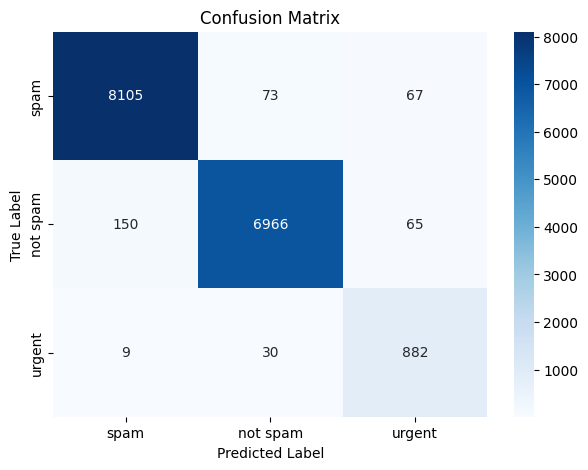

In [ ]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Cell 2: Load datasets from CSV files in the same folder
enron_df = pd.read_csv("email_text_enron.csv")  # columns: label (0/1), text
trec_df = pd.read_csv("email_text_trec.csv")    # columns: label (0/1), text

print("Enron shape:", enron_df.shape)
print("TREC shape:", trec_df.shape)

# Combine datasets
df = pd.concat([enron_df, trec_df], ignore_index=True)
print("Combined dataset shape:", df.shape)

# Check label distribution (spam=1, ham=0)
print("Label distribution:\n", df['label'].value_counts())

# Cell 3: Add urgent label based on keywords
def label_urgent(row):
    text = str(row['text']).lower()
    urgent_keywords = r"\b(urgent|asap|immediate|important)\b"
    if re.search(urgent_keywords, text):
        return "urgent"
    else:
        return "spam" if row['label'] == 1 else "not spam"

df['new_label'] = df.apply(label_urgent, axis=1)

print("New label distribution:")
print(df['new_label'].value_counts())

# Cell 4: Text preprocessing function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove emails
    text = re.sub(r'\S+@\S+', ' ', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', ' ', text)
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize and remove stopwords, then lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing to all texts
df['clean_text'] = df['text'].apply(preprocess_text)

# Cell 5: Vectorization with TF-IDF (unigrams + bigrams, max_features=7000)
vectorizer = TfidfVectorizer(
    max_features=10000,      # Try 10000 or higher if your RAM allows
    ngram_range=(1,3),       # Include unigrams, bigrams, trigrams
    min_df=2,                # Ignore terms that appear in only 1 doc
    sublinear_tf=True        # Sublinear term frequency scaling
)
X = vectorizer.fit_transform(df['clean_text'])
y = df['new_label']

# Cell 6: Train-test split stratified on new_label
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Cell 7: Train Logistic Regression with OneVsRestClassifier
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# Train model as before, but on the balanced data
clf = OneVsRestClassifier(
    LogisticRegression(class_weight='balanced', max_iter=2000, solver='liblinear')
)
clf.fit(X_train_bal, y_train_bal)

# Cell 8: Predictions and evaluation
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Cell 9: Confusion matrix plot
labels_order = ["spam", "not spam", "urgent"]
cm = confusion_matrix(y_test, y_pred, labels=labels_order)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=labels_order,
            yticklabels=labels_order,
            cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def predict_email_category(text):
    # Preprocess and vectorize the input text (same vectorizer!)
    text_vector = vectorizer.transform([text])

    # Predict with the trained model
    prediction = clf.predict(text_vector)[0]

    return prediction


In [ ]:
# Example inputs for each category
examples = {
    "spam": [
        "Congratulations! You've won a $1000 gift card. Click here to claim now!",
        "Earn money quickly with no effort, limited time offer!"
    ],
    "not spam": [
        "Hi team, the meeting is scheduled for tomorrow at 10 AM.",
        "Please find the attached report for last quarter's performance."
    ],
    "urgent": [
        "This is urgent! Please respond ASAP.",
        "Immediate action required on your account, please verify your information."
    ]
}

# Test and print predictions
for category, texts in examples.items():
    print(f"\nCategory: {category.upper()}")
    for text in texts:
        pred = predict_email_category(text)
        print(f"Text: {text}\nPredicted label: {pred}\n")



Category: SPAM
Text: Congratulations! You've won a $1000 gift card. Click here to claim now!
Predicted label: spam

Text: Earn money quickly with no effort, limited time offer!
Predicted label: spam


Category: NOT SPAM
Text: Hi team, the meeting is scheduled for tomorrow at 10 AM.
Predicted label: not spam

Text: Please find the attached report for last quarter's performance.
Predicted label: not spam


Category: URGENT
Text: This is urgent! Please respond ASAP.
Predicted label: urgent

Text: Immediate action required on your account, please verify your information.
Predicted label: urgent

